In [54]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [55]:
import keras
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate, AveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
import numpy as np
from tensorflow.keras.optimizers import Adam


In [56]:
class DenseNet:
    def __init__(self, input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, nb_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.nb_classes = nb_classes
        
    def build_model(self):
        img_input = Input(shape=self.input_shape, name='img_input')
        nb_channels = self.growth_rate
        
        x = Conv2D(2*self.growth_rate, (3,3), 
                   padding='same', strides = (1,1), 
                   kernel_regularizer=keras.regularizers.l2(self.weight_decay))(img_input)
        
        for block in range(self.dense_blocks-1):
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                              self.dropout_rate, self.bottleneck, self.weight_decay)
            
            x = self.transition_layer(x, nb_channels, self.dropout_rate, self.compression, self.weight_decay)
            nb_channels = int(nb_channels*self.compression)
            
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels, self.growth_rate, self.dropout_rate, self.weight_decay)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = GlobalAveragePooling2D()(x)
        prediction = Dense(self.nb_classes, activation='softmax')(x)
        
        return Model(inputs=img_input, outputs=prediction, name='densenet')
        
    def dense_block(self, x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        for i in range(nb_layers):
            cb = self.convolution_block(x, growth_rate, dropout_rate, bottleneck)
            nb_channels += growth_rate
            x = concatenate([cb,x])
            
        return x, nb_channels
    
    def convolution_block(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):       

        # Bottleneck
        if bottleneck:
            bottleneckWidth = 4
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(nb_channels * bottleneckWidth, (1, 1),
                                     kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
            # Dropout
            if dropout_rate:
                x = Dropout(dropout_rate)(x)

        # Standard (BN-ReLU-Conv)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels, (3, 3), padding='same')(x)

        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        return x

    def transition_layer(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x

In [57]:
densenet = DenseNet((28,28,1), nb_classes=10, depth=35)
model = densenet.build_model()
model_optimizer = Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [58]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = np.reshape(train_images,(60000,28,28,1))
test_images = np.reshape(test_images,(10000,28,28,1))
y_test_1 = np.zeros((10000,10))
y_test_1[np.arange(10000),test_labels]=1
y = np.zeros((60000,10))
y[np.arange(60000),train_labels]=1

In [59]:
model.fit(x=train_images, y=y, batch_size=64, epochs=1)

938/938 [==============================] - 146s 148ms/step - loss: 0.5538 - acc: 0.8366


In [61]:
x_train = train_images / 255.
x_test = test_images / 255.
y_train = np.where(y == 1)[1]
y_test = np.where(y_test_1 == 1)[1]
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [62]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [63]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

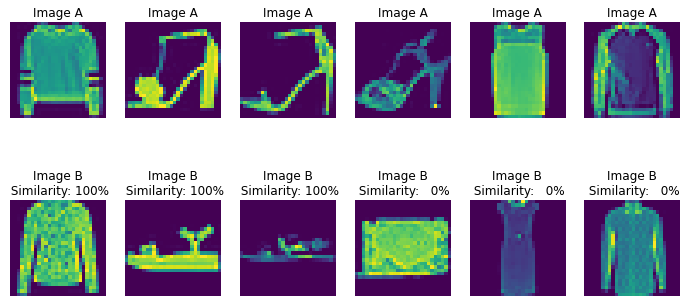

In [64]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [65]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d_137 (Conv2D)         (None, 26, 26, 8)         80        
                                                                 
 batch_normalization_143 (Ba  (None, 26, 26, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_143 (Activation)  (None, 26, 26, 8)        0         
                                                                 
 conv2d_138 (Conv2D)         (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_144 (Ba  (None, 24, 24,

In [66]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [67]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


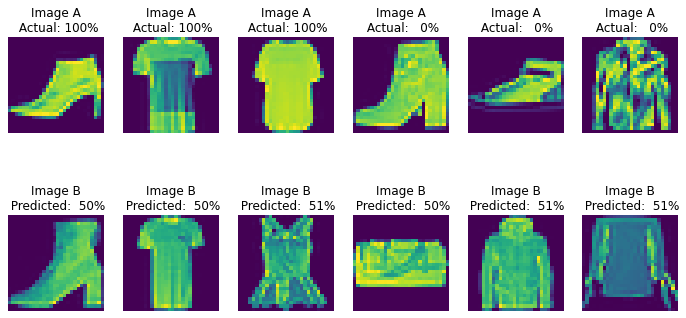

In [68]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [69]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                                               epochs = 10,
                                             verbose = True)

Epoch 1/10
500/500 [==============================] - 30s 55ms/step - loss: 0.6591 - accuracy: 0.5679
Epoch 2/10
500/500 [==============================] - 28s 55ms/step - loss: 0.5391 - accuracy: 0.7275
Epoch 3/10
500/500 [==============================] - 28s 56ms/step - loss: 0.4734 - accuracy: 0.7780
Epoch 4/10
500/500 [==============================] - 28s 56ms/step - loss: 0.4439 - accuracy: 0.7974
Epoch 5/10
500/500 [==============================] - 27s 55ms/step - loss: 0.4245 - accuracy: 0.8091
Epoch 6/10
500/500 [==============================] - 28s 57ms/step - loss: 0.4021 - accuracy: 0.8232
Epoch 7/10
500/500 [==============================] - 31s 61ms/step - loss: 0.3935 - accuracy: 0.8260
Epoch 8/10
500/500 [==============================] - 28s 55ms/step - loss: 0.3845 - accuracy: 0.8329
Epoch 9/10
500/500 [==============================] - 28s 55ms/step - loss: 0.3731 - accuracy: 0.8384
Epoch 10/10
500/500 [==============================] - 29s 57ms/step - loss: 0.382

In [70]:
test_acc = model.evaluate(test_images, y_test_1)[1]

print('Test accuracy:', test_acc)

313/313 [==============================] - 13s 36ms/step - loss: 0.7597 - acc: 0.7871
Test accuracy: 0.7871000170707703


In [71]:
train_acc = model.evaluate(train_images, y)[1]

print('Test accuracy:', train_acc)

1875/1875 [==============================] - 66s 35ms/step - loss: 0.7329 - acc: 0.7933
Test accuracy: 0.7933499813079834


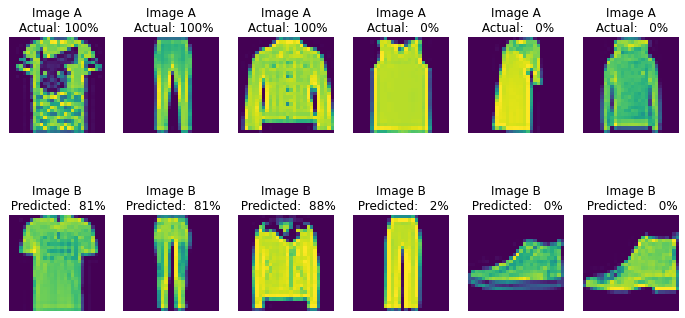

In [72]:
_ = show_model_output()


In [73]:
x_test_features = feature_model.predict(test_images, verbose = True, batch_size=128)


79/79 [==============================] - 0s 3ms/step


In [74]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 2.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 24.167314
[t-SNE] Computed conditional probabilities in 0.761s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 64.3669434, gradient norm = 0.0132377 (50 iterations in 5.501s)
[t-SNE] Iteration 100: error = 67.9354858, gradient norm = 0.0120257 (50 iterations in 5.218s)
[t-SNE] Iteration 150: error = 68.8241653, gradient norm = 0.0098403 (50 iterations in 4.950s)
[t-SNE] Iteration 200: error = 69.2354279, gradient norm = 0.0092899 (50 iterations in 4.699s)
[t-SNE] Iteration 250: error = 69.5522156, gradient norm = 0.0085095 (50 iterations in 4.514s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.552216
[t-SNE] Iteration 300: error = 1.9434514, gradient norm = 0.0008236 (50 iterations in 4.690s)
[t-SNE] Iteration 350: error = 1.8097436, gradient norm = 0.0003100 (50 iterations in 5.012s)
[t-SNE] Iteration 400: error = 1.7606564, gradient norm = 0.0002022 (50 iterations in 5.080s)
[t-SNE] Iteration 450: error = 1.7290177, gradient norm = 0.0001570 (50 iterations in 5.075s)
[t-SNE] Iteration 500: error = 1.7038536, gradient norm = 0.0001351 (50 

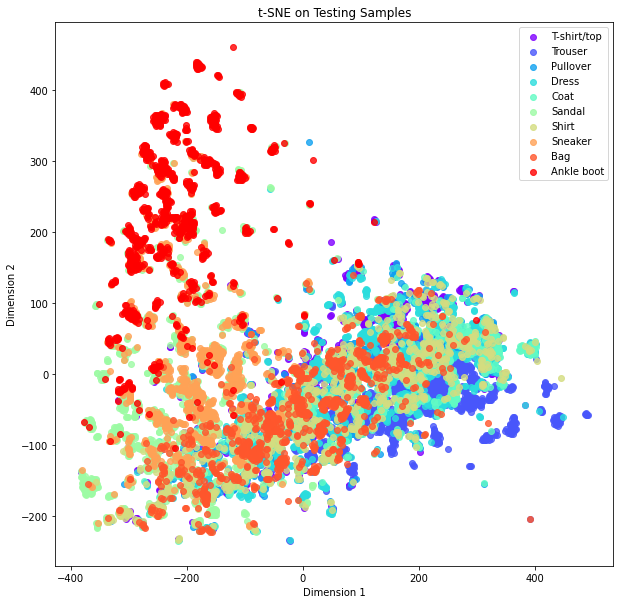

In [75]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10)) 
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0],  tsne_features[np.where(y_test == c_group), 1],  marker='o', 
  color=c_color, 
  linewidth='1', 
  alpha=0.8, 
  label=c_label) 
plt.xlabel('Dimension 1') 
plt.ylabel('Dimension 2') 
plt.title('t-SNE on Testing Samples') 
plt.legend(loc='best')  
plt.show(block=False)